In [1]:
from google.cloud import bigquery
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn import linear_model
from scipy import stats
from sklearn.model_selection import train_test_split,cross_validate
import statsmodels.api as sm

# Read and create data frames for Rent_Data

In [2]:
file = ("Source/Rent_Data201_All.csv")

In [3]:
rent_df = pd.read_csv(file, index_col=None, sep=',', header=0)

In [4]:
rent_df.shape

(633907, 27)

# Explore & Clean data

In [5]:
rent_df.head()

,id,created_on,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat_lon,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,693b976b8ba980af13f1fccc00b1fde348b970cd,2015-03-20,rent,house,Jalisco,|México|Jalisco|,México,Jalisco,NaN,"20.652503,-103.269094",...,64.0,NaN,31.250000,NaN,NaN,NaN,http://www.properati.com.mx/4fut_renta_casa_ja...,Casa en renta en MISION CANTERA. 2 habitacione...,Casa en Renta en Tonalá,https://thumbs4.properati.com/6/kS_UudajkTNMF-...
1,44f0e48c028081ac1eeb3c1a436e84c6b32fdf48,2015-03-27,rent,house,Morelos,|México|Morelos|,México,Morelos,NaN,NaN,...,591.0,NaN,47.377327,NaN,NaN,NaN,http://www.properati.com.mx/4k0u_renta_casa_mo...,Casa en renta en EMILIANO ZAPATA. 4 habitacion...,Casa en Renta en Cuautla,https://thumbs4.properati.com/1/U1Dw2-w4P7Xa_c...
2,8c4724a97758b43a3cd79fdbc428c1d278d54407,2015-03-25,rent,house,Morelos,|México|Morelos|,México,Morelos,NaN,NaN,...,101.0,NaN,69.306931,NaN,NaN,NaN,http://www.properati.com.mx/4isy_renta_casa_mo...,Casa en renta en FRACC. TULIPANES. 3 habitacio...,Casa en Renta en Cuautla,https://thumbs4.properati.com/1/W9x22fBC2uhGWU...
3,6a10b6a928f8692ad490c4b4dfedaeaa294ab969,2015-03-29,rent,house,Morelos,|México|Morelos|,México,Morelos,NaN,NaN,...,160.0,NaN,31.250000,NaN,NaN,NaN,http://www.properati.com.mx/4l7b_renta_casa_mo...,Casa en renta en Miguel Hidalgo. 3 habitacione...,Casa en Renta en Cuautla,https://thumbs4.properati.com/1/Xp_fT_UlHhP_Rp...
4,ed80bc5c8e98f4a25800caffcd3d77261ee6d870,2015-01-29,rent,house,Morelos,|México|Morelos|,México,Morelos,NaN,"18.864874,-98.925911",...,NaN,0.54132,NaN,NaN,NaN,NaN,http://www.properati.com.mx/3duz_renta_casa_mo...,"SE VENDE CASA EN EL FRACC. BRISAS DE CUAUTLA, ...",RENTA CASA CUAUTLA BRISAS CO.,https://thumbs4.properati.com/3/nnJuaRAIo-x2Q5...


In [6]:
rent_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 633907 entries, 0 to 633906
Data columns (total 27 columns):
id                            633907 non-null object
created_on                    633907 non-null object
operation                     633907 non-null object
property_type                 633907 non-null object
place_name                    633907 non-null object
place_with_parent_names       633907 non-null object
country_name                  633907 non-null object
state_name                    633907 non-null object
geonames_id                   0 non-null float64
lat_lon                       483779 non-null object
lat                           483779 non-null float64
lon                           483779 non-null float64
price                         616063 non-null float64
currency                      590343 non-null object
price_aprox_local_currency    616063 non-null float64
price_aprox_usd               616063 non-null float64
surface_total_in_m2           389396 non

The following columns where deleted because they represent repetitive data in the dataframes or information that is not relevant for the intended analysis. The "Country_name" column is deleted because all the analysis is made for Mexico so we do not need that extra space in the final table. The "price_aprox_local_currency" also is deleted because there is already information regarding both currencies. Also I deleted the columns "Price_per_m2" both of them because having the price & the total m2 is just division between them so it will be the same.

In [7]:
del rent_df["image_thumbnail"], rent_df["lat_lon"], rent_df["geonames_id"], rent_df["title"]
del rent_df["properati_url"], rent_df['country_name'], rent_df['price_aprox_local_currency']
del rent_df["price_per_m2"], rent_df['price_usd_per_m2'], rent_df['floor'], rent_df['rooms']
del rent_df['expenses'], rent_df["place_with_parent_names"], rent_df["description"]

Working with dates, to get only the information since 2015

In [8]:
rent_df['created_on'] = pd.to_datetime(rent_df.created_on)

In [9]:
start_date = "2015-01-01"
end_date = rent_df['created_on'].max()

In [10]:
mask = (rent_df['created_on'] >= start_date) & (rent_df['created_on'] <= end_date)
rent_df = rent_df.loc[mask]

In [11]:
sorted(rent_df.created_on.unique())

[numpy.datetime64('2015-01-05T00:00:00.000000000'),
 numpy.datetime64('2015-01-06T00:00:00.000000000'),
 numpy.datetime64('2015-01-07T00:00:00.000000000'),
 numpy.datetime64('2015-01-08T00:00:00.000000000'),
 numpy.datetime64('2015-01-09T00:00:00.000000000'),
 numpy.datetime64('2015-01-10T00:00:00.000000000'),
 numpy.datetime64('2015-01-11T00:00:00.000000000'),
 numpy.datetime64('2015-01-12T00:00:00.000000000'),
 numpy.datetime64('2015-01-13T00:00:00.000000000'),
 numpy.datetime64('2015-01-14T00:00:00.000000000'),
 numpy.datetime64('2015-01-15T00:00:00.000000000'),
 numpy.datetime64('2015-01-16T00:00:00.000000000'),
 numpy.datetime64('2015-01-17T00:00:00.000000000'),
 numpy.datetime64('2015-01-20T00:00:00.000000000'),
 numpy.datetime64('2015-01-21T00:00:00.000000000'),
 numpy.datetime64('2015-01-22T00:00:00.000000000'),
 numpy.datetime64('2015-01-23T00:00:00.000000000'),
 numpy.datetime64('2015-01-24T00:00:00.000000000'),
 numpy.datetime64('2015-01-25T00:00:00.000000000'),
 numpy.datet

Next I have to delete all the row that contains "Null" values, this is because I neede complete information for the analysis. Also if the rent price is 0, then it represent a missing information take in consideration that you will not get your return of investment with 0 values

In [12]:
rent_df = rent_df[~rent_df['price'].isna()]
rent_df = rent_df[~rent_df['lat'].isna()]
rent_df = rent_df[~rent_df['lat'].isna()]
rent_df = rent_df[rent_df['price'] != 0]

In [13]:
rent_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 445582 entries, 0 to 633906
Data columns (total 13 columns):
id                       445582 non-null object
created_on               445582 non-null datetime64[ns]
operation                445582 non-null object
property_type            445582 non-null object
place_name               445582 non-null object
state_name               445582 non-null object
lat                      445582 non-null float64
lon                      445582 non-null float64
price                    445582 non-null float64
currency                 445582 non-null object
price_aprox_usd          445582 non-null float64
surface_total_in_m2      270355 non-null float64
surface_covered_in_m2    405837 non-null float64
dtypes: datetime64[ns](1), float64(6), object(6)
memory usage: 47.6+ MB


In [14]:
store = rent_df[rent_df['property_type'] == "store"]

In [15]:
store.describe()

,lat,lon,price,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2
count,99158.000000,99158.000000,9.915800e+04,99158.000000,64224.000000,9.093200e+04
mean,21.754915,-99.336575,2.925328e+04,1739.705120,336.513173,4.117701e+02
std,3.505561,5.396285,5.644423e+04,3616.284211,2555.728401,1.350645e+04
min,14.879236,-117.123691,5.000000e+01,50.000000,0.000000,-1.000000e+00
25%,19.284744,-100.954916,7.500000e+03,430.320000,0.000000,4.000000e+01
50%,20.671845,-99.614647,1.500000e+04,835.530000,56.000000,8.000000e+01
75%,24.155968,-97.838407,3.000000e+04,1708.395000,190.000000,2.000000e+02
max,32.665445,-86.746136,1.749000e+06,100000.000000,176550.000000,1.270014e+06


As we can observe from the previous information of the table the columns regarding surface still not have rigth informatio, there is still "Nan" values and outliers. So it will be necesary to combanie both columns as they represent the same data and then clean the "NaN's" 

In [16]:
rent_df['surface_total_in_m2'] = rent_df["surface_total_in_m2"].fillna(rent_df['surface_covered_in_m2'])
del rent_df['surface_covered_in_m2']

In [17]:
rent_df['surface_total_in_m2'] = rent_df["surface_total_in_m2"].fillna(0)
rent_df = rent_df[rent_df['surface_total_in_m2'] != 0]

## OUTLIERS

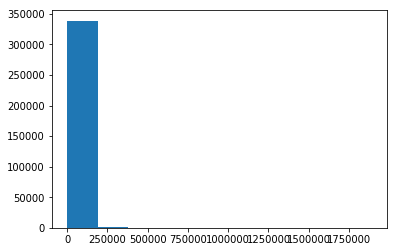

In [18]:
plt.hist(rent_df.price)
plt.show()

Next I will work with quartiles to take off the outliers in the data, assuming that the maximun payable monthly rent by a person will be about 130 000 MX and the minumun 4500 according to the Taxes Mexican Law (http://congreso.investiga.fca.unam.mx/docs/xvii/docs/G06.pdf). Doing a little reasearch in Mexico is not conviniet having rents hieghr than that because the taxes will be kill your bussines. Also the rent law says that monthly rents must be less that 10% of the total value of the property

In [19]:
lower_bound = 0.1
upper_bound = 0.99
out = rent_df.price.quantile([lower_bound, upper_bound])
out

0.10      4500.0
0.99    130000.0
Name: price, dtype: float64

In [20]:
true_index = (out.loc[lower_bound] <= rent_df.price.values)&\
(rent_df.price.values <= out.loc[upper_bound])

false_index = ~true_index

In [21]:
rent_df['price'] = rent_df.price[true_index]

In [22]:
rent_df['price'] = rent_df.price.fillna(0)
rent_df = rent_df[rent_df['price'] != 0]

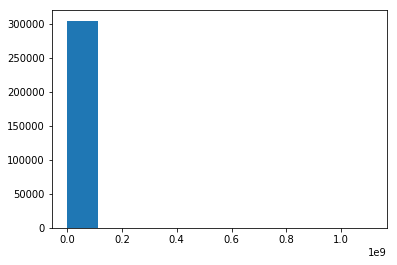

In [23]:
plt.hist(rent_df.surface_total_in_m2)
plt.show()

The square meters can have a surface higher that 1000 in the cases of a big store or wharehouse. Regarding properties for living I have assume it will not be bigger that 600 square meters, and this because of the reasearch mention before in the analysis.

In [24]:
lower_bound = 0.1
upper_bound = 0.95
out = rent_df.surface_total_in_m2.quantile([lower_bound, upper_bound])
out

0.10     64.0
0.95    907.0
Name: surface_total_in_m2, dtype: float64

In [25]:
true_index = (out.loc[lower_bound] <= rent_df.surface_total_in_m2.values)&\
(rent_df.surface_total_in_m2.values <= out.loc[upper_bound])

false_index = ~true_index

In [26]:
rent_df['surface_total_in_m2'] = rent_df.surface_total_in_m2[true_index]

In [27]:
rent_df['surface_total_in_m2'] = rent_df.surface_total_in_m2.fillna(0)
rent_df = rent_df[rent_df['surface_total_in_m2'] != 0]

In [28]:
rent_df['state_name'] = rent_df.state_name.replace(['Distrito Federal'], 'Ciudad de México')

In [29]:
rent_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258567 entries, 4 to 633898
Data columns (total 12 columns):
id                     258567 non-null object
created_on             258567 non-null datetime64[ns]
operation              258567 non-null object
property_type          258567 non-null object
place_name             258567 non-null object
state_name             258567 non-null object
lat                    258567 non-null float64
lon                    258567 non-null float64
price                  258567 non-null float64
currency               258567 non-null object
price_aprox_usd        258567 non-null float64
surface_total_in_m2    258567 non-null float64
dtypes: datetime64[ns](1), float64(5), object(6)
memory usage: 25.6+ MB


# Regression & Corralation

In [30]:
rent_df.describe()

,lat,lon,price,price_aprox_usd,surface_total_in_m2
count,258567.000000,258567.000000,258567.000000,258567.000000,258567.000000
mean,20.752811,-98.528083,19763.575224,1153.705824,225.348242
std,2.691265,4.412680,15990.595751,1617.440544,161.607911
min,14.899375,-131.641445,4500.000000,205.660000,64.000000
25%,19.075247,-100.394511,9500.000000,524.000000,113.000000
50%,20.388239,-99.254997,15000.000000,831.420000,173.000000
75%,21.072905,-97.861135,25000.000000,1338.700000,280.000000
max,89.916756,-86.746136,130000.000000,100000.000000,907.000000


In the following graph we can notice that the price not necessarly increase or decrease depending the square meters. So it will deppend in the zone you are renting as well, including the Sate in the country. It will be clear once the data is clean

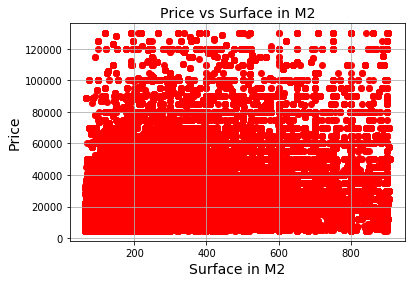

In [31]:
plt.scatter(rent_df['surface_total_in_m2'],rent_df['price'], color='red')
plt.title('Price vs Surface in M2', fontsize=14)
plt.xlabel('Surface in M2', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.grid(True)
plt.show()

To prove this result I am going to run a linear regression using the independent variable as state and square meter to verify which one has grater impact in the depend variable ("Price")

In [32]:
dummy = pd.get_dummies(rent_df.state_name)

In [33]:
merge = pd.concat([rent_df,dummy], axis='columns')

In [34]:
merge.head()

,id,created_on,operation,property_type,place_name,state_name,lat,lon,price,currency,...,Quintana Roo,San Luis Potosí,Sinaloa,Sonora,Tabasco,Tamaulipas,Tlaxcala,Veracruz de Ignacio de la Llave,Yucatán,Zacatecas
4,ed80bc5c8e98f4a25800caffcd3d77261ee6d870,2015-01-29,rent,house,Morelos,Morelos,18.864874,-98.925911,6500.0,MXN,...,0,0,0,0,0,0,0,0,0,0
5,7b85bf7a1bd32f5ff46e6640d5e76a31bd747e52,2015-01-05,rent,house,Morelos,Morelos,18.837368,-98.941242,7000.0,MXN,...,0,0,0,0,0,0,0,0,0,0
10,e11cfdc485256c33a8af75e9b614293efdea5c05,2015-01-05,rent,store,Morelos,Morelos,18.823515,-98.949789,5000.0,MXN,...,0,0,0,0,0,0,0,0,0,0
11,f148cbb2c2ff6ad7476f44d219b7af14bc717754,2015-01-05,rent,house,Morelos,Morelos,18.824124,-98.948113,10000.0,MXN,...,0,0,0,0,0,0,0,0,0,0
13,c108c5e0def8a486e4d43945aa4e7cef1dda5cae,2015-01-05,rent,store,Tabasco,Tabasco,17.994583,-93.386271,8000.0,MXN,...,0,0,0,0,1,0,0,0,0,0


In [35]:
X = merge.drop(['id', 'created_on', 'operation', 'property_type', 'place_name',
       'state_name', 'lat', 'lon', 'price', 'currency', 'price_aprox_usd'], axis='columns') 
y = merge['price']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [37]:
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 6784.933829308458
Coefficients: 
 [   46.98254619 -1576.1437573   1892.87199349 -2171.32159509
    68.56940335 -1527.5465428   1094.55507447 14975.81122919
 -4270.68621242 -1026.66229183 -3781.68999156  4914.41241036
 -1302.03269545 -6316.11891144 -1589.15383465  5639.79502801
 -9524.08680317 -3516.46132577 -1576.41261568 10102.24231069
  2081.37955485  2000.11479335  2402.06755765  4998.85596772
  1561.42240755  -594.73396578  -830.48895656   394.38649593
 -2997.56212971 -2101.37349078  -570.74527811 -4085.58738873
 -2767.6764398 ]


In both models it is clear that the 33 state variables has more impcat in the prices as the coeficient is higher that the square meters coeficiant and the 33 are closer to the constant coeficient. It is also good to notice that R-squared is not less that the 50% so the model is not very accurate to explain the varince of the dependent variable.

In [38]:
# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

C:\Users\w10\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     3683.
Date:                Mon, 01 Jul 2019   Prob (F-statistic):               0.00
Time:                        19:36:34   Log-Likelihood:            -2.8212e+06
No. Observations:              258567   AIC:                         5.642e+06
Df Residuals:                  258534   BIC:                         5.643e+06
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [39]:
rent_df.to_csv("Results/rent_data_Mexico_since_2015.csv", index=False)